In [18]:
import os
import re
import cv2
import nltk
import json
import random
import torch
import pickle
import numpy as np
from lib.configure.config import Config
from models.Model7 import Model7
from lib.dataset.coco_dataset import CocoCaptions
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torchvision import transforms
from torch.autograd import Variable
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Test embedding-attention net

In [24]:
# Load Pretrained Model.
class opts():
    class_num = 4
    batch_size = 64
    resume = './checkpoint/Model8_flickr_P5_attr_regu_regre_regionpooling_exp10-200.pth'
    
print("Preparing data set...")
opts.ite = 0
size = (1024, 1024)
feat_size = (128, 128)
img_path = '/media/drive1/Data/coco17/train2017/'
json = '/media/drive1/Data/coco17/annotations/captions_train2017.json'
attribute_path = '/media/drive1/unsupervised_grounding/attribute_grounding/others/low-level-attr.txt'
dictionary_path = '/media/drive1/unsupervised_grounding/attribute_grounding/others/dictionary_emb.pkl'

transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
data_set = CocoCaptions(img_path, json, transform)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=opts.batch_size, shuffle=True)
model = Model7(opts)

m = torch.nn.Upsample(scale_factor=16, mode='bilinear')  # align_corners=False

# Load Back bone Module
if opts.resume:
    state_dict = torch.load(opts.resume)['state_dict']
    new_params = model.state_dict()
    new_params.update(state_dict)
    # Remove the extra keys
    model_keys = model.state_dict().keys()
    for name, param in list(new_params.items()):
        if name not in model_keys:
            del new_params[name]
    model.load_state_dict(new_params)
model.cuda()
model = model.eval()

# Load Word Embedding
print('loading dictionary...')
with open(dictionary_path, 'rb') as f:
    embeddings_index = pickle.load(f)

Preparing data set...
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
==> Building backbone model...
loading dictionary...


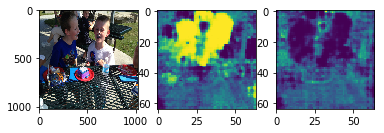

In [27]:
i = 3272

images, attr_one_hot, entity_one_hot = data_set[i]
images = Variable(torch.from_numpy(images).view(1, images.shape[0], images.shape[1], images.shape[2])).cuda()
entity_one_hot = Variable(torch.from_numpy(entity_one_hot)).view(1, -1).cuda().float()

# Load dictionary
list_file = open(attribute_path, 'r')
entity_att = []
for i in list_file.readlines():
    entity_att.append(i.replace('\n', ''))

# Feed in network
        
# Make plot with vertical (default) colorbar
plt.subplot(131)
plt.imshow(images[0].data.permute(1,2,0).float().cpu())

plt.subplot(132)
embeddings = Variable(torch.zeros(1, 300)).cuda()
i = 'boy'
embeddings[0] = Variable(torch.from_numpy(embeddings_index[i])).cuda()
single_attribute_label = Variable(torch.from_numpy(np.asarray([0]))).cuda()
y, attr_map, att_conv_feature = model(images, single_attribute_label, embeddings)
cax=plt.imshow(attr_map[0,0].data.cpu().numpy())


plt.subplot(133)
embeddings = Variable(torch.zeros(1, 300)).cuda()
i = 'girl'
embeddings[0] = Variable(torch.from_numpy(embeddings_index[i])).cuda()
single_attribute_label = Variable(torch.from_numpy(np.asarray([0]))).cuda()
y, attr_map, att_conv_feature = model(images, single_attribute_label, embeddings)
cax=plt.imshow(attr_map[0,0].data.cpu().numpy())



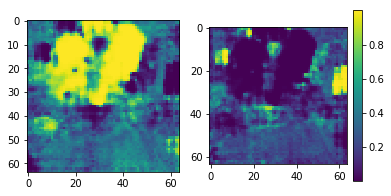

In [29]:

plt.subplot(121)
embeddings = Variable(torch.zeros(1, 300)).cuda()
i = 'man'
embeddings[0] = Variable(torch.from_numpy(embeddings_index[i])).cuda()
single_attribute_label = Variable(torch.from_numpy(np.asarray([0]))).cuda()
y, attr_map, att_conv_feature = model(images, single_attribute_label, embeddings)
cax=plt.imshow(attr_map[0,0].data.cpu().numpy())


plt.subplot(122)
embeddings = Variable(torch.zeros(1, 300)).cuda()
i = 'lady'
embeddings[0] = Variable(torch.from_numpy(embeddings_index[i])).cuda()
single_attribute_label = Variable(torch.from_numpy(np.asarray([0]))).cuda()
y, attr_map, att_conv_feature = model(images, single_attribute_label, embeddings)
cax=plt.imshow(attr_map[0,0].data.cpu().numpy())
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = plt.colorbar(cax, fraction=0.056, pad=0.04)

# Tesing other words (unseen words)

In [10]:
# Load Word Embedding
print('loading dictionary...')
embeddings_index = {}
f = open('glove.6B.' + str(300) + 'd.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype=np.float32)
    embeddings_index[word] = coefs

loading dictionary...
